In [1]:
import matplotlib.pyplot as plt
import torch
import pytorch3d
import numpy as np

from co3d.dataset.dataset_zoo import dataset_zoo
from co3d.dataset.dataloader_zoo import dataloader_zoo

In [2]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d

class Arrow3D(FancyArrowPatch):
    def __init__(self, xs, ys, zs, *args, **kwargs):
        FancyArrowPatch.__init__(self, (0,0), (0,0), *args, **kwargs)
        self._verts3d = xs, ys, zs

    def draw(self, renderer):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
        self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))
        FancyArrowPatch.draw(self, renderer)

In [3]:
category = "teddybear"
task = "singlesequence"
single_sequence_id = 0

datasets = dataset_zoo(
        category=category,
        assert_single_seq=task == "singlesequence",
        dataset_name=f"co3d_{task}",
        test_on_train=False,
        load_point_clouds=True,
        test_restrict_sequence_id=single_sequence_id,
    )

set_names_mapping :{'train': ['test_known'], 'val': ['test_known', 'test_unseen'], 'test': ['test_known', 'test_unseen']}
Dataset :  train
subsets :  ['test_known']
Loading Co3D frames from ../dataset/CO3D/teddybear/frame_annotations.jgz.
Loading Co3D sequences from ../dataset/CO3D/teddybear/sequence_annotations.jgz.
Loading Co3D subset lists from ../dataset/CO3D/teddybear/set_lists.json.
Removing images with empty masks.
... filtered 72865 -> 63135
Limitting Co3D dataset to the '['test_known']' subsets.
pick_sequence: ['34_1479_4753']
... filtered 75 -> 1
CO3D Dataset #frames=81
Dataset :  val
subsets :  ['test_known', 'test_unseen']
Loading Co3D frames from ../dataset/CO3D/teddybear/frame_annotations.jgz.
Loading Co3D sequences from ../dataset/CO3D/teddybear/sequence_annotations.jgz.
Loading Co3D subset lists from ../dataset/CO3D/teddybear/set_lists.json.
Removing images with empty masks.
... filtered 72865 -> 63135
Limitting Co3D dataset to the '['test_known', 'test_unseen']' subset

In [4]:
dataloaders = dataloader_zoo(
        datasets,
        dataset_name=f"co3d_{task}",
    )

dataset_set : train, dataset : CO3D Dataset #frames=81, batch_size : 1, dataset_len : 1000, dataset_len_val : 1, images_per_seq_options : [2]
dataset_set : val, dataset : CO3D Dataset #frames=102, batch_size : 1, dataset_len : 1000, dataset_len_val : 1, images_per_seq_options : [2]
dataset_set : test, dataset : CO3D Dataset #frames=102, batch_size : 1, dataset_len : 1000, dataset_len_val : 1, images_per_seq_options : [2]


In [36]:
train_dataset = datasets["train"]
train_dataloader = dataloaders["train"]

test_dataset = datasets["test"]
test_dataloader = dataloaders["test"]

print(len(train_dataloader), len(test_dataloader))

1000 100


In [37]:
frame_data = next(iter(test_dataloader))

In [38]:
cameras = frame_data.camera
imgs = frame_data.image_rgb
img_paths = frame_data.image_path
h, w = imgs.shape[-2:]

print(len(imgs))
print(imgs.shape)
print(h, w)

10
torch.Size([10, 3, 800, 800])
800 800


In [39]:
ndc2screen_true = pytorch3d.renderer.cameras.get_ndc_to_screen_transform(cameras, image_size=(h, w), with_xyflip=True)
ndc2screen_true.get_matrix()[0]

tensor([[-399.5000,    0.0000,    0.0000,    0.0000],
        [   0.0000, -399.5000,    0.0000,    0.0000],
        [   0.0000,    0.0000,    1.0000,    0.0000],
        [ 399.5000,  399.5000,    0.0000,    1.0000]])

In [40]:
ndc2screen_false = pytorch3d.renderer.cameras.get_ndc_to_screen_transform(cameras, image_size=(h, w), with_xyflip=False)
ndc2screen_false.get_matrix()[0]

tensor([[ 399.5000,    0.0000,    0.0000,    0.0000],
        [   0.0000,  399.5000,    0.0000,    0.0000],
        [   0.0000,    0.0000,    1.0000,    0.0000],
        [-399.5000, -399.5000,    0.0000,    1.0000]])

In [41]:
# left-top
print(ndc2screen_true.transform_points(torch.tensor([[1., 1., 1.0000]]))[0])

# right-bottom
print(ndc2screen_true.transform_points(torch.tensor([[-1., -1., 1.0000]]))[0])

tensor([[0., 0., 1.]])
tensor([[799., 799.,   1.]])


In [42]:
# left-top
print(ndc2screen_false.transform_points(torch.tensor([[1., 1., 1.0000]]))[0])

# right-bottom
print(ndc2screen_false.transform_points(torch.tensor([[-1., -1., 1.0000]]))[0])

tensor([[0., 0., 1.]])
tensor([[-799., -799.,    1.]])


In [43]:
screen2ndc_true = pytorch3d.renderer.cameras.get_screen_to_ndc_transform(cameras, image_size=(h, w), with_xyflip=True)
screen2ndc_true.get_matrix()[0]

tensor([[-0.0025,  0.0000,  0.0000,  0.0000],
        [ 0.0000, -0.0025,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  1.0000,  0.0000],
        [ 1.0000,  1.0000,  0.0000,  1.0000]])

In [44]:
screen2ndc_false = pytorch3d.renderer.cameras.get_screen_to_ndc_transform(cameras, image_size=(h, w), with_xyflip=False)
screen2ndc_false.get_matrix()[0]

tensor([[0.0025, -0.0000, 0.0000, -0.0000],
        [0.0000, 0.0025, 0.0000, -0.0000],
        [0.0000, 0.0000, 1.0000, -0.0000],
        [1.0000, 1.0000, 0.0000, 1.0000]])

In [45]:
# left-top
print(screen2ndc_true.transform_points(torch.tensor([[0., 0., 1.0000]]))[0])

# right-bottom
print(screen2ndc_true.transform_points(torch.tensor([[799., 799., 1.0000]]))[0])

# center
print(screen2ndc_true.transform_points(torch.tensor([[399., 399., 1.0000]]))[0])

tensor([[1., 1., 1.]])
tensor([[-1., -1.,  1.]])
tensor([[0.0013, 0.0013, 1.0000]])


In [46]:
# left-top
print(screen2ndc_false.transform_points(torch.tensor([[0., 0., 1.0000]]))[0])

# right-bottom
print(screen2ndc_false.transform_points(torch.tensor([[799., 799., 1.0000]]))[0])

# center
print(screen2ndc_false.transform_points(torch.tensor([[399., 399., 1.0000]]))[0])

tensor([[1., 1., 1.]])
tensor([[3., 3., 1.]])
tensor([[1.9987, 1.9987, 1.0000]])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


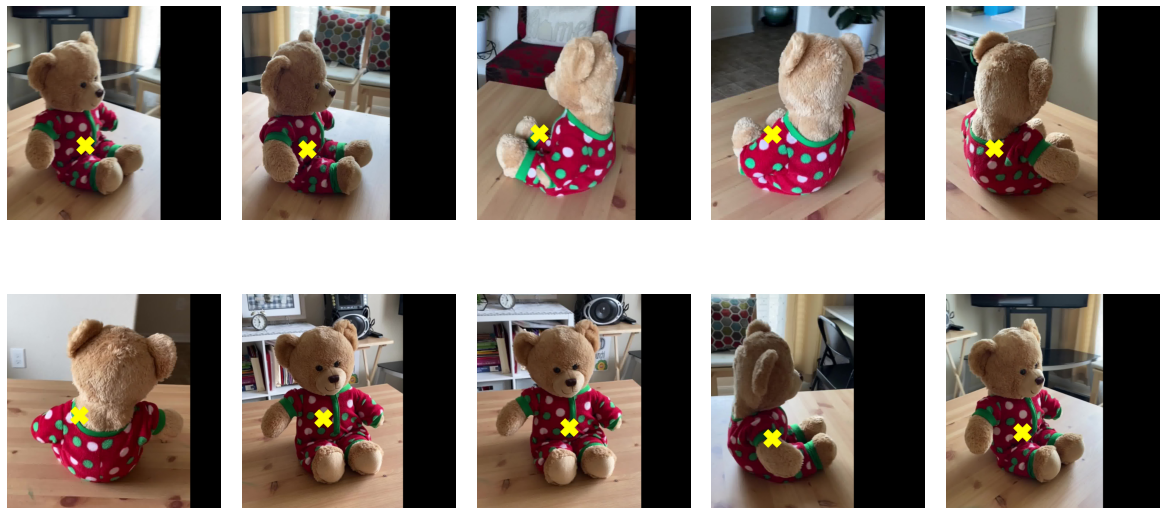

In [47]:
plt.figure(figsize=(16, 8))
plt.subplots_adjust(wspace=0.1, hspace=0, left=0, right=1, bottom=0, top=1)

# ndc coord --> screen coord
ndc2screen = pytorch3d.renderer.cameras.get_ndc_to_screen_transform(cameras, 
                                                                    image_size=(h, w), with_xyflip=True)

for i in range(len(imgs)):
    plt.subplot(2, 5, i + 1)
    img = imgs[i, :, :].numpy().transpose(1, 2, 0)
    plt.imshow(img)

    principal_ndc = cameras.principal_point[i]

    principal_with_z = torch.ones((1, 3))
    principal_with_z[..., :2] = principal_ndc

    principal_screen = ndc2screen.transform_points(principal_with_z)[i]

    plt.scatter(principal_screen[0][0].item(), principal_screen[0][1].item(), marker='X', c='yellow', s=300)
    
    plt.axis("off")

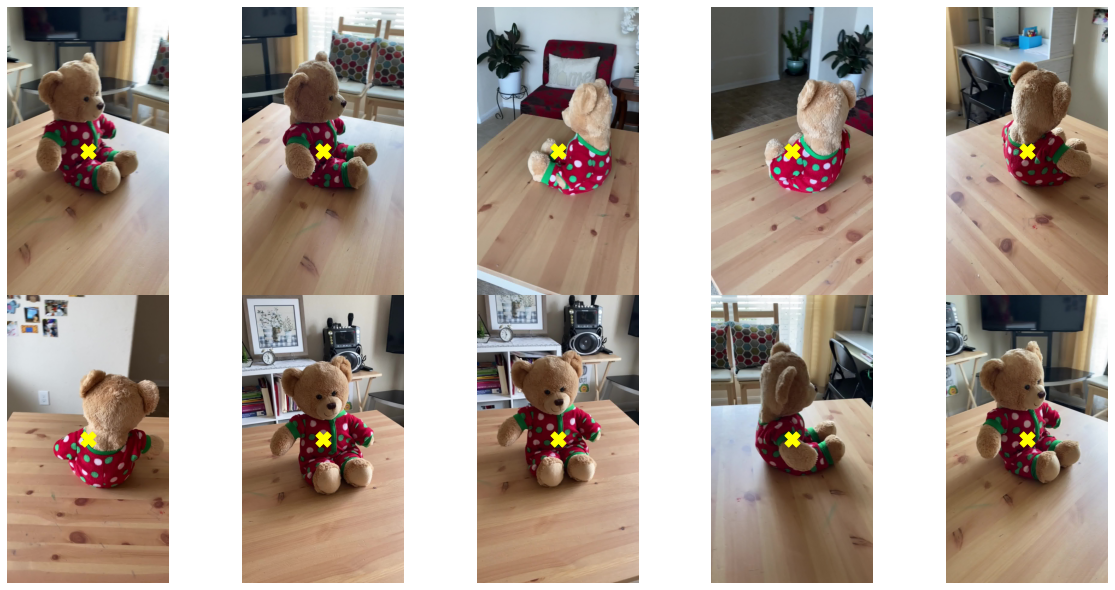

In [48]:
import PIL.Image as Image

plt.figure(figsize=(16, 8))
plt.subplots_adjust(wspace=0.1, hspace=0, left=0, right=1, bottom=0, top=1)

for i in range(len(imgs)):
    plt.subplot(2, 5, i + 1)
    img_path = img_paths[i]
    img = Image.open(img_path)
    h, w = img.height, img.width

    plt.imshow(img)

    cy, cx = h/2, w/2
    plt.scatter(cx, cy, marker='X', c='yellow', s=230)
    
    plt.axis("off")

In [49]:
camera_centers = cameras.get_camera_center().numpy()

print(camera_centers)

[[-4.7442493e+00 -1.7324615e-01 -8.2143326e+00]
 [-6.6329622e+00 -1.0741161e+00 -6.4680662e+00]
 [ 8.0743866e+00 -6.6494827e+00  2.2161500e+00]
 [ 4.1682062e+00 -7.9289980e+00  5.1924033e+00]
 [-7.5477600e+00 -5.5741262e+00  1.8720030e+00]
 [-1.9346607e+00 -7.9842768e+00  5.5387163e+00]
 [-1.6124303e-02  8.8859051e-01 -9.7607660e+00]
 [ 3.5548466e-01  1.8706036e-01 -9.8571548e+00]
 [-8.3427677e+00 -3.1711545e+00 -2.6218138e+00]
 [-4.1942782e+00 -5.3683519e-03 -8.4197817e+00]]


In [50]:
c2w = cameras.get_world_to_view_transform().inverse().get_matrix()

c2w_Rs = c2w[:, :3, :3]
c2w_Ts = c2w[:, 3, :3]

print(c2w[0])
print(c2w_Rs[0])
print(c2w_Ts[0])

tensor([[-0.8319, -0.2223,  0.5086,  0.0000],
        [ 0.2648, -0.9642,  0.0117,  0.0000],
        [ 0.4878,  0.1443,  0.8610,  0.0000],
        [-4.7442, -0.1732, -8.2143,  1.0000]])
tensor([[-0.8319, -0.2223,  0.5086],
        [ 0.2648, -0.9642,  0.0117],
        [ 0.4878,  0.1443,  0.8610]])
tensor([-4.7442, -0.1732, -8.2143])


In [51]:
w2c = cameras.get_world_to_view_transform().get_matrix()
w2c_Rs = w2c[:, :3, :3]
w2c_Ts = w2c[:, 3, :3]

print(w2c[0])
print(w2c_Rs[0])
print(w2c_Ts[0])

tensor([[-0.8319,  0.2648,  0.4878,  0.0000],
        [-0.2223, -0.9642,  0.1443,  0.0000],
        [ 0.5086,  0.0117,  0.8610,  0.0000],
        [ 0.1924,  1.1848,  9.4113,  1.0000]])
tensor([[-0.8319,  0.2648,  0.4878],
        [-0.2223, -0.9642,  0.1443],
        [ 0.5086,  0.0117,  0.8610]])
tensor([0.1924, 1.1848, 9.4113])


/tmp/ipykernel_144349/1589115755.py:12: MatplotlibDeprecationWarning: 
The M attribute was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use self.axes.M instead.
  xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)


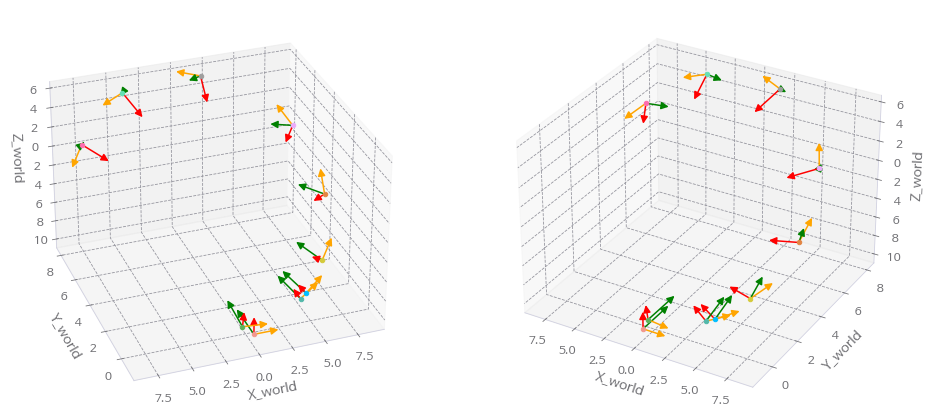

In [52]:
fig = plt.figure(figsize=(16, 8))

ax = plt.subplot(1, 2, 1, projection='3d')

ax.view_init(elev=None, azim=70)

ax.set_xlabel("X_world")
ax.set_ylabel("Y_world")
ax.set_zlabel("Z_world")

for (camera_center, R) in zip(camera_centers, c2w_Rs):
    x, y, z = camera_center
    ax.scatter3D(x, y, z, cmap='blues')

    R = R.T
    # 카메라의 +x, +y, +z축
    xx, xy, xz = R[:3, 0]*2
    yx, yy, yz = R[:3, 1]*2
    zx, zy, zz = R[:3, 2]*2

    # 카메라의 x축 그리기
    xs = [x, x+xx]
    ys = [y, y+xy]
    zs = [z, z+xz]
    a = Arrow3D(xs, ys, zs, mutation_scale=15, 
                lw=1.5, arrowstyle="-|>", color="orange")
    ax.add_artist(a)

    # 카메라의 y축 그리기
    xs = [x, x+yx]
    ys = [y, y+yy]
    zs = [z, z+yz]
    a = Arrow3D(xs, ys, zs, mutation_scale=15, 
                lw=1.5, arrowstyle="-|>", color="g")
    ax.add_artist(a)

    # 카메라의 z축 그리기
    xs = [x, x+zx]
    ys = [y, y+zy]
    zs = [z, z+zz]
    a = Arrow3D(xs, ys, zs, mutation_scale=15, 
                lw=1.5, arrowstyle="-|>", color="r")
    ax.add_artist(a)
############################################################
ax = plt.subplot(1, 2, 2, projection='3d')

ax.view_init(elev=30, azim=120)

ax.set_xlabel("X_world")
ax.set_ylabel("Y_world")
ax.set_zlabel("Z_world")

for (camera_center, R) in zip(c2w_Ts, c2w_Rs):
    x, y, z = camera_center
    ax.scatter3D(x, y, z, cmap='blues')

    R = R.T
    # 카메라의 +x, +y, +z축
    xx, xy, xz = R[:3, 0]*2
    yx, yy, yz = R[:3, 1]*2
    zx, zy, zz = R[:3, 2]*2

    # 카메라의 x축 그리기
    xs = [x, x+xx]
    ys = [y, y+xy]
    zs = [z, z+xz]
    a = Arrow3D(xs, ys, zs, mutation_scale=15, 
                lw=1.5, arrowstyle="-|>", color="orange")
    ax.add_artist(a)

    # 카메라의 y축 그리기
    xs = [x, x+yx]
    ys = [y, y+yy]
    zs = [z, z+yz]
    a = Arrow3D(xs, ys, zs, mutation_scale=15, 
                lw=1.5, arrowstyle="-|>", color="g")
    ax.add_artist(a)

    # 카메라의 z축 그리기
    xs = [x, x+zx]
    ys = [y, y+zy]
    zs = [z, z+zz]
    a = Arrow3D(xs, ys, zs, mutation_scale=15, 
                lw=1.5, arrowstyle="-|>", color="r")
    ax.add_artist(a)
    

In [53]:
xyz = torch.randn(10, 1, 3) # 3D points of shape (batch_size, num_points, 3)
print(xyz[0])
# transform xyz to the camera view coordinates
xyz_cam = cameras.get_world_to_view_transform().transform_points(xyz)
print(xyz_cam[0])
# extract the depth of each point as the 3rd coord of xyz_cam
depth = xyz_cam[:, :, 2:]
# project the points xyz to the camera
xy = cameras.transform_points(xyz)[:, :, :2]
print(xy[0])
# append depth to xy
xy_depth = torch.cat((xy, depth), dim=2)
# unproject to the world coordinates
xyz_unproj_world = cameras.unproject_points(xy_depth, world_coordinates=True)
print(xyz_unproj_world[0])


print(torch.allclose(xyz, xyz_unproj_world)) # True
# unproject to the camera coordinates
xyz_unproj = cameras.unproject_points(xy_depth, world_coordinates=False)
print(xyz_unproj[0])

print(torch.allclose(xyz_cam, xyz_unproj)) # True

tensor([[ 1.7397, -2.1443,  0.6175]])
tensor([[-0.4642,  3.7202, 10.4820]])
tensor([[0.1453, 0.6865]])
tensor([[ 1.7397, -2.1443,  0.6175]])
False
tensor([[-0.4642,  3.7202, 10.4820]])
True


***

## Screen 좌표 체계로 이미지의 각 픽셀 별 좌표를 만들음

In [54]:
cam_idx = 0

In [55]:
img = frame_data.image_rgb[0]

W = img.shape[2]
H = img.shape[1]
print(f"Width : {W} / Height : {H}")

u, v = np.meshgrid(np.arange(W), np.arange(H))

# 이미지의 각 row들이 한 줄로 이어붙은 형태로 변환
# (H, W) --> (H*W)
u = u.reshape(-1).astype(dtype=np.float32)  # + 0.5    # add half pixel
v = v.reshape(-1).astype(dtype=np.float32)  # + 0.5

pixels = np.stack((u, v, np.ones_like(u)), axis=0)  # [3(x+y+z), H*W]? 아니면 homogeneous coordinate라 1을 추가한 건지?
pixels = torch.from_numpy(pixels)
batched_pixels = pixels.unsqueeze(0).repeat(1, 1, 1)

# bmm : batch matrix-matrix product 
# [B, N, M] tensor * [B, M, P] tensor >>> [B, N, P]
screen_px = batched_pixels.transpose(1, 2).reshape(-1, 3)
# rays_o = torch.tensor([0, 0, 0], dtype=torch.float32).unsqueeze(0).repeat(1, rays_d.shape[0], 1).reshape(-1, 3)

Width : 800 / Height : 800


In [56]:
u, v = np.meshgrid(np.arange(W), np.arange(H))

In [57]:
len(u)

800

In [58]:
# print("< rays_o in screen >\n", rays_o.shape, '\n', rays_o[:5])
print("\n< pixels in screen >\n", screen_px.shape, '\n', screen_px[:5])


< pixels in screen >
 torch.Size([640000, 3]) 
 tensor([[0., 0., 1.],
        [1., 0., 1.],
        [2., 0., 1.],
        [3., 0., 1.],
        [4., 0., 1.]])


In [59]:
# screen >>> ndc

ndc_px = screen2ndc_true.transform_points(screen_px)[cam_idx]
# rays_o_ndc = screen2ndc_true.transform_points(rays_o)[cam_idx]

In [60]:
# print("< rays_o in ndc >\n", rays_o_ndc.shape, '\n', rays_o_ndc[:5])
print("\n< pixels in ndc >\n", ndc_px.shape, '\n', ndc_px[:5])


< pixels in ndc >
 torch.Size([640000, 3]) 
 tensor([[1.0000, 1.0000, 1.0000],
        [0.9975, 1.0000, 1.0000],
        [0.9950, 1.0000, 1.0000],
        [0.9925, 1.0000, 1.0000],
        [0.9900, 1.0000, 1.0000]])


In [61]:
screen_bound = [screen_px[0], screen_px[W-1], screen_px[W*(H-1)], screen_px[-1]]
screen_bound = torch.stack(screen_bound)

# image_bound_o = [rays_o[0], rays_o[W-1], rays_o[W*(H-1)], rays_o[-1]]
# image_bound_o = torch.stack(image_bound_o)

print("< Bound in screen>\n", screen_bound)

< Bound in screen>
 tensor([[  0.,   0.,   1.],
        [799.,   0.,   1.],
        [  0., 799.,   1.],
        [799., 799.,   1.]])


In [62]:
ndc_bound = [ndc_px[0], ndc_px[W-1], ndc_px[W*(H-1)], ndc_px[-1]]
ndc_bound = torch.stack(ndc_bound)

# image_bound_o_ndc = [rays_o_ndc[0], rays_o_ndc[W-1], rays_o_ndc[W*(H-1)], rays_o_ndc[-1]]
# image_bound_o_ndc = torch.stack(image_bound_o_ndc)

print("< Bound in ndc >\n", ndc_bound)

< Bound in ndc >
 tensor([[ 1.,  1.,  1.],
        [-1.,  1.,  1.],
        [ 1., -1.,  1.],
        [-1., -1.,  1.]])


Principal point in Screen :  tensor([[292.5203, 517.4227,   1.0000]])


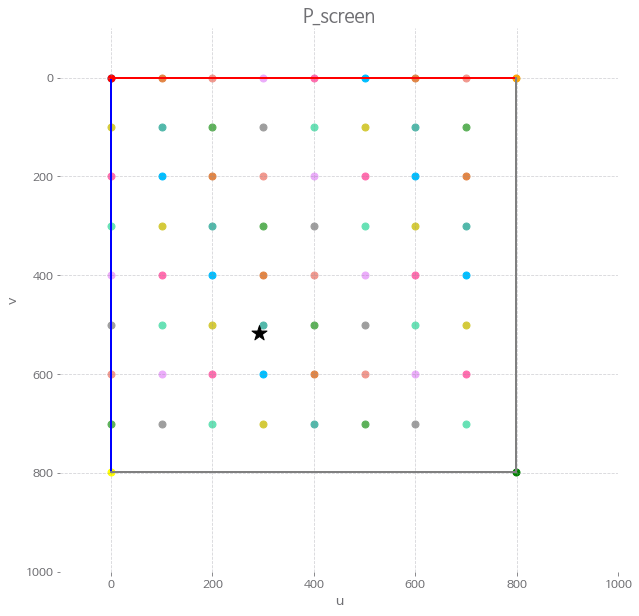

In [63]:
fig = plt.figure(figsize=(10, 10))

plt.title("P_screen")
plt.xlabel("u")
plt.ylabel("v")

plt.xlim(-100, 1000)  # u축 (=x)
plt.ylim(1000, -100)  # v축 (=y)


# Screen 좌표계에서 정의된 각 픽셀 좌표 시각화
xs = screen_px[:W][::100][:, 0]        # screen pixels의 width(0 ~ 799)를 100 간격으로 나눔
ys = screen_px[::W][::100][:, 1]                  # screen pixels의 height(0 ~ 799)를 100 간격으로 나눔

for x in xs:
    for y in ys:
        plt.scatter(x.item(), y.item(), cmap='b')


ndc2screen_true = pytorch3d.renderer.cameras.get_ndc_to_screen_transform(cameras, image_size=(800, 800), with_xyflip=True)

principal = torch.ones((1, 3))
principal[:, :2] = cameras.principal_point[cam_idx]
principal_screen = ndc2screen_true.transform_points(principal)[cam_idx]
print("Principal point in Screen : ", principal_screen)

plt.scatter(principal_screen[0][0].item(), principal_screen[0][1].item(), c='black', marker='*', s=250)

# screen의 left_top
left_top = screen_bound[0].numpy()
plt.scatter(left_top[0], left_top[1], c='red')
# screen의 right_top
right_top = screen_bound[1].numpy()
plt.scatter(right_top[0], right_top[1], c='orange')
# screen의 left_bottom
left_bottom = screen_bound[2].numpy()
plt.scatter(left_bottom[0], left_bottom[1], c='yellow')
# screen의 right_bottom
right_bottom = screen_bound[3].numpy()
plt.scatter(right_bottom[0], right_bottom[1], c='green')

# left
plt.plot(np.linspace(left_top[0], left_bottom[0]), np.linspace(left_top[1], left_bottom[1]), 'blue')
# top
plt.plot(np.linspace(left_top[0], right_top[0]), np.linspace(left_top[1], right_top[1]), 'red')
# right
plt.plot(np.linspace(right_top[0], right_bottom[0]), np.linspace(right_top[1], right_bottom[1]), 'gray')
# bottom
plt.plot(np.linspace(right_bottom[0], left_bottom[0]), np.linspace(right_bottom[1], left_bottom[1]), 'gray')

Principal point in NDC :  tensor([[ 0.2678, -0.2952,  1.0000]])


/home/M2020802/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/M2020802/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


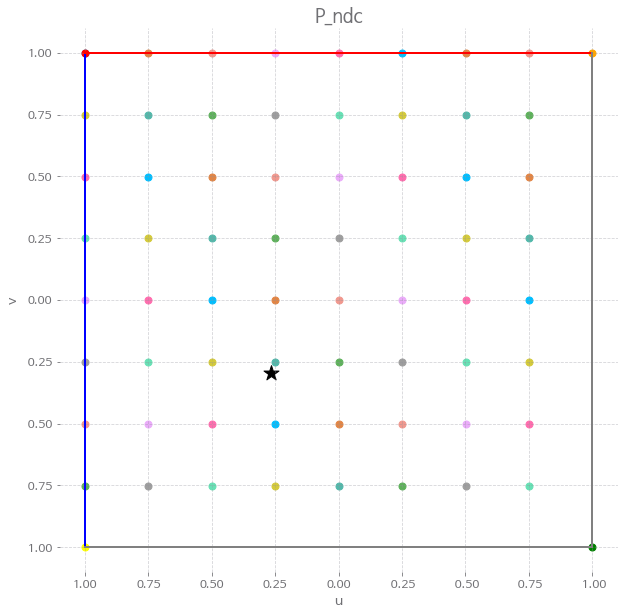

In [64]:
fig = plt.figure(figsize=(10, 10))

ax = fig.add_subplot(1, 1, 1)
ax.set_title("P_ndc")
ax.set_xlabel("u")
ax.set_ylabel("v")

# ax.set_xlim(-1.5, 1.5)  # u축 (=x)
# ax.set_ylim(1.5, -1.5)  # v축 (=y)
ax.invert_xaxis()
# ax.invert_yaxis()

# NDC 좌표계에서 정의된 각 픽셀 좌표 시각화
xs = ndc_px[:W][::100][:, 0]        # ndc pixels의 width(0 ~ 799)를 100 간격으로 나눔
ys = ndc_px[::W][::100][:, 1]                  # ndc pixels의 height(0 ~ 799)를 100 간격으로 나눔

for x in xs:
    for y in ys:
        ax.scatter(x.item(), y.item(), cmap='b')

principal_ndc = torch.ones((1, 3))
principal_ndc[:, :2] = cameras.principal_point[cam_idx]
print("Principal point in NDC : ", principal_ndc)

ax.scatter(principal_ndc[0][0].item(), principal_ndc[0][1].item(), c='black', marker='*', s=250)

# screen의 left_top
left_top = ndc_bound[0].numpy()
ax.scatter(left_top[0], left_top[1], c='red')
# screen의 right_top
right_top = ndc_bound[1].numpy()
ax.scatter(right_top[0], right_top[1], c='orange')
# screen의 left_bottom
left_bottom = ndc_bound[2].numpy()
ax.scatter(left_bottom[0], left_bottom[1], c='yellow')
# screen의 right_bottom
right_bottom = ndc_bound[3].numpy()
ax.scatter(right_bottom[0], right_bottom[1], c='green')

# left
ax.plot(np.linspace(left_top[0], left_bottom[0]), np.linspace(left_top[1], left_bottom[1]), 'blue')
# top
ax.plot(np.linspace(left_top[0], right_top[0]), np.linspace(left_top[1], right_top[1]), 'red')
# right
ax.plot(np.linspace(right_top[0], right_bottom[0]), np.linspace(right_top[1], right_bottom[1]), 'gray')
# bottom
ax.plot(np.linspace(right_bottom[0], left_bottom[0]), np.linspace(right_bottom[1], left_bottom[1]), 'gray')

***

# ndc -> camera

In [65]:
# K_inv만 곱해서 NDC >> Camera 좌표계로 변환한 ray
K_inv = cameras.get_projection_transform()[cam_idx].inverse()
rays_d_cam = K_inv.transform_points(ndc_px)
# rays_o_cam = K_inv.transform_points(rays_o)
rays_o_cam = torch.zeros_like(rays_d_cam)

print(rays_d_cam.shape)
print(rays_o_cam.shape)

print("(0, 0) screen pixel in ndc : ", ndc_px[0])
print("(0, 0) pixel ray in camera : ", rays_d_cam[0])
print()
print("(W-1, 0) screen pixel in ndc : ", ndc_px[W-1])
print("(W_1, 0) pixel ray in camera : ", rays_d_cam[W-1])
print()
print("(0, H-1) screen pixel in ndc : ", ndc_px[W*(H-1)])
print("(0, H-1) pixel ray in camera : ", rays_d_cam[W*(H-1)])
print()
print("(W-1, H-1) screen pixel in ndc : ", ndc_px[-1])
print("(W-1, H-1) pixel ray in camera : ", rays_d_cam[-1])

torch.Size([640000, 3])
torch.Size([640000, 3])
(0, 0) screen pixel in ndc :  tensor([1., 1., 1.])
(0, 0) pixel ray in camera :  tensor([0.2647, 0.4683, 1.0000])

(W-1, 0) screen pixel in ndc :  tensor([-1.,  1.,  1.])
(W_1, 0) pixel ray in camera :  tensor([-0.4584,  0.4683,  1.0000])

(0, H-1) screen pixel in ndc :  tensor([ 1., -1.,  1.])
(0, H-1) pixel ray in camera :  tensor([ 0.2647, -0.2548,  1.0000])

(W-1, H-1) screen pixel in ndc :  tensor([-1., -1.,  1.])
(W-1, H-1) pixel ray in camera :  tensor([-0.4584, -0.2548,  1.0000])


In [66]:
cam_bound_ray = K_inv.transform_points(ndc_bound)

print(cam_bound_ray)

tensor([[ 0.2647,  0.4683,  1.0000],
        [-0.4584,  0.4683,  1.0000],
        [ 0.2647, -0.2548,  1.0000],
        [-0.4584, -0.2548,  1.0000]])


/tmp/ipykernel_144349/1589115755.py:12: MatplotlibDeprecationWarning: 
The M attribute was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use self.axes.M instead.
  xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)


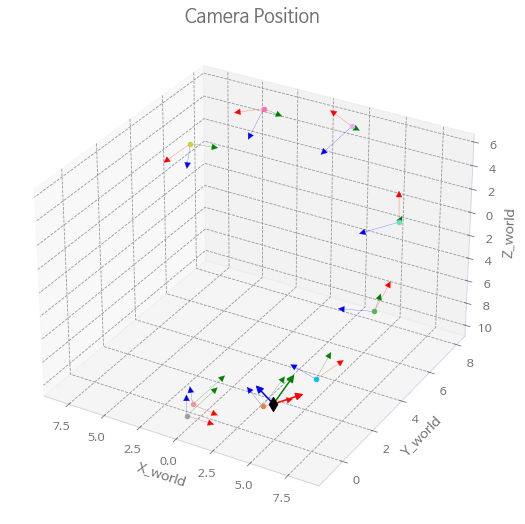

In [67]:
fig = plt.figure(figsize=(16, 9))

ax = plt.axes(projection='3d')

ax.set_title("Camera Position")

ax.set_xlabel("X_world")
ax.set_ylabel("Y_world")
ax.set_zlabel("Z_world")

ax.view_init(elev=30, azim=120)

for i, (camera_center, R) in enumerate(zip(camera_centers, c2w_Rs)):
    x, y, z = camera_center

    R = R.T
    # 카메라의 +x, +y, +z축
    xx, xy, xz = R[:3, 0]*2
    yx, yy, yz = R[:3, 1]*2
    zx, zy, zz = R[:3, 2]*2

    if i == cam_idx:
        ax.scatter3D(x, y, z, c='black', marker='d', s=100)
        lw_size = 1.5
    else:
        ax.scatter3D(x, y, z, cmap='blues')
        lw_size = 0.2

    # 카메라의 x축 그리기
    xs = [x, x+xx]
    ys = [y, y+xy]
    zs = [z, z+xz]
    a = Arrow3D(xs, ys, zs, mutation_scale=15, 
                lw=lw_size, arrowstyle="-|>", color="r")
    ax.add_artist(a)

    # 카메라의 y축 그리기
    xs = [x, x+yx]
    ys = [y, y+yy]
    zs = [z, z+yz]
    a = Arrow3D(xs, ys, zs, mutation_scale=15, 
                lw=lw_size, arrowstyle="-|>", color="g")
    ax.add_artist(a)

    # 카메라의 z축 그리기
    xs = [x, x+zx]
    ys = [y, y+zy]
    zs = [z, z+zz]
    a = Arrow3D(xs, ys, zs, mutation_scale=15, 
                lw=lw_size, arrowstyle="-|>", color="b")
    ax.add_artist(a)

Principal point in cam :  tensor([[0., 0., 1.]])


/tmp/ipykernel_144349/1589115755.py:12: MatplotlibDeprecationWarning: 
The M attribute was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use self.axes.M instead.
  xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)


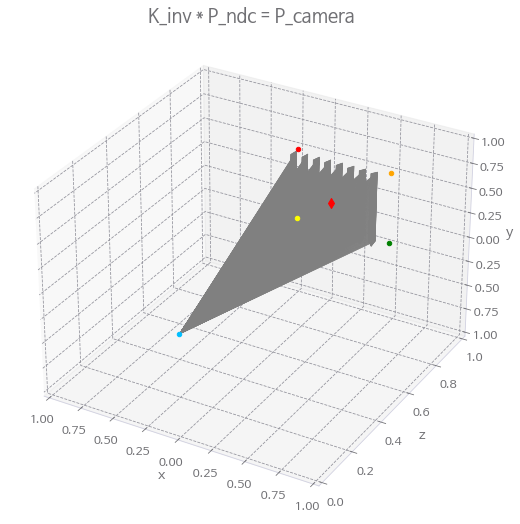

In [68]:
fig = plt.figure(figsize=(16, 9))
ax = plt.axes(projection='3d')

ax.set_title("K_inv * P_ndc = P_camera")

ax.set_xlabel("x")
ax.set_ylabel("z")
ax.set_zlabel("y")

ax.set_xlim3d(1, -1)  # u축 (=x)
ax.set_ylim3d(0, 1)     # z축 (=1)
ax.set_zlim3d(-1, 1)  # v축 (=y)

# intrinsic_inv만 곱한 ray 시각화
for ray_o, ray_d in zip(rays_o_cam[::300], rays_d_cam[::300]):
    xs = [ray_o[0].item(), ray_d[0].item()]
    ys = [ray_o[1].item(), ray_d[1].item()]
    zs = [ray_o[2].item(), ray_d[2].item()]

    a = Arrow3D(xs, zs, ys, mutation_scale=15, 
                    lw=0.5, arrowstyle="-|>", color="gray")
    ax.add_artist(a)

x, y, z = ray_o[0].item(), ray_o[1].item(), ray_o[2].item()
ax.scatter3D(x, z, y, cmap='Greens')

principal_ = torch.ones(1, 3)
principal_[..., :2] = principal_ndc[..., :2]
principal_cam = K_inv.transform_points(principal_)
print("Principal point in cam : ", principal_cam)

x, y, z = principal_cam[0][0].item(), principal_cam[0][1].item(), principal_cam[0][2].item()
ax.scatter3D(x, z, y, c='red', marker='d', s=50)

# image의 left_top
left_top = cam_bound_ray[0].numpy()
ax.scatter3D(left_top[0], left_top[2], left_top[1], c='red')
# image의 right_top
right_top = cam_bound_ray[1].numpy()
ax.scatter3D(right_top[0], right_top[2], right_top[1], c='orange')
# image의 left_bottom
left_bottom = cam_bound_ray[2].numpy()
ax.scatter3D(left_bottom[0], left_bottom[2], left_bottom[1], c='yellow')
# image의 right_bottom
right_bottom = cam_bound_ray[3].numpy()
ax.scatter3D(right_bottom[0], right_bottom[2], right_bottom[1], c='green')



여기서 K_inv를 곱했기 때문에 principal point 값이 (0, 0)이 된다.

***

# camera -> world

In [69]:
c2w = cameras.get_world_to_view_transform()[cam_idx].inverse()
rays_d_world = c2w.transform_points(rays_d_cam)
rays_o_world = c2w.transform_points(rays_o_cam)
print(rays_d_world.shape)
print(rays_o_world.shape)

print("(0, 0) pixel in screen : ", screen_px[0])
print("(0, 0) pixel in ndc : ", ndc_px[0])
print("(0, 0) pixel ray in camera : ", rays_d_cam[0])
print("(0, 0) pixel ray in world : ", rays_d_world[0])
print()
print("(1, 0) pixel in screen : ", screen_px[1])
print("(1, 0) pixel in ndc : ", ndc_px[1])
print("(1, 0) pixel ray in camera : ", rays_d_cam[1])
print("(1, 0) pixel ray in world : ", rays_d_world[1])
print()
print("(0, 1) pixel in screen : ", screen_px[W])
print("(0, 1) pixel in ndc : ", ndc_px[W])
print("(0, 1) pixel ray in camera : ", rays_d_cam[W])
print("(0, 1) pixel ray in world : ", rays_d_world[W])

torch.Size([640000, 3])
torch.Size([640000, 3])
(0, 0) pixel in screen :  tensor([0., 0., 1.])
(0, 0) pixel in ndc :  tensor([1., 1., 1.])
(0, 0) pixel ray in camera :  tensor([0.2647, 0.4683, 1.0000])
(0, 0) pixel ray in world :  tensor([-4.3527, -0.5393, -7.2133])

(1, 0) pixel in screen :  tensor([1., 0., 1.])
(1, 0) pixel in ndc :  tensor([0.9975, 1.0000, 1.0000])
(1, 0) pixel ray in camera :  tensor([0.2638, 0.4683, 1.0000])
(1, 0) pixel ray in world :  tensor([-4.3520, -0.5391, -7.2138])

(0, 1) pixel in screen :  tensor([0., 1., 1.])
(0, 1) pixel in ndc :  tensor([1.0000, 0.9975, 1.0000])
(0, 1) pixel ray in camera :  tensor([0.2647, 0.4674, 1.0000])
(0, 1) pixel ray in world :  tensor([-4.3530, -0.5384, -7.2133])


In [70]:
world_bound_ray = c2w.transform_points(cam_bound_ray)

print(world_bound_ray)

tensor([[-4.3527, -0.5393, -7.2133],
        [-3.7512, -0.3786, -7.5810],
        [-4.5442,  0.1580, -7.2217],
        [-3.9426,  0.3187, -7.5895]])


In [79]:
print(principal_cam)

principal_world = c2w.transform_points(principal_cam)[0]
print(principal_world)

tensor([[0., 0., 1.]])
tensor([-4.2565, -0.0289, -7.3534])


/home/M2020802/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/tmp/ipykernel_144349/1589115755.py:12: MatplotlibDeprecationWarning: 
The M attribute was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use self.axes.M instead.
  xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
/home/M2020802/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


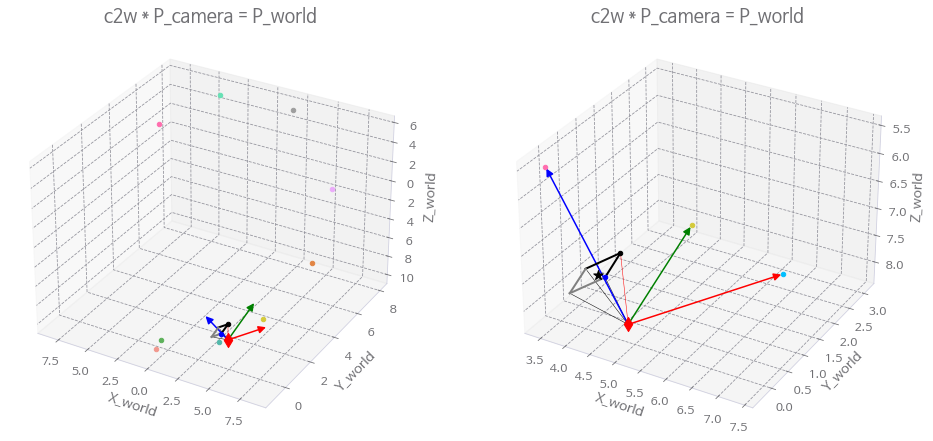

In [82]:
fig = plt.figure(figsize=(16, 8))
ax = fig.add_subplot(1, 2, 1, projection='3d')

ax.set_title("c2w * P_camera = P_world")

ax.set_xlabel("X_world")
ax.set_ylabel("Y_world")
ax.set_zlabel("Z_world")

ax.view_init(elev=30, azim=120)

for i, (camera_center, R) in enumerate(zip(camera_centers, c2w_Rs)):
    x, y, z = camera_center
    ax.scatter3D(x, y, z, cmap='blues')

    R = R.T
    
    if i == cam_idx:
        ax.scatter3D(x, y, z, c='red', marker='d', s=100)

        for i, ray_d in enumerate(world_bound_ray):
            xs = [x, ray_d[0].item()]
            ys = [y, ray_d[1].item()]
            zs = [z, ray_d[2].item()]

            if i == 0:
                a = Arrow3D(xs, ys, zs, mutation_scale=15, 
                                lw=0.5, arrowstyle="-", color="r")
            else:
                a = Arrow3D(xs, ys, zs, mutation_scale=15, 
                                lw=0.5, arrowstyle="-", color="black")
            ax.add_artist(a)
            
        left_top = world_bound_ray[0].numpy()
        right_top = world_bound_ray[1].numpy()
        left_bottom = world_bound_ray[2].numpy()
        right_bottom = world_bound_ray[3].numpy()

        # left
        ax.plot(np.linspace(left_top[0], left_bottom[0]), np.linspace(left_top[1], left_bottom[1]), np.linspace(left_top[2], left_bottom[2]), 'black')
        # top
        ax.plot(np.linspace(left_top[0], right_top[0]), np.linspace(left_top[1], right_top[1]), np.linspace(left_top[2], right_top[2]), 'black')
        # right
        ax.plot(np.linspace(right_top[0], right_bottom[0]), np.linspace(right_top[1], right_bottom[1]), np.linspace(right_top[2], right_bottom[2]), 'gray')
        # bottom
        ax.plot(np.linspace(right_bottom[0], left_bottom[0]), np.linspace(right_bottom[1], left_bottom[1]), np.linspace(right_bottom[2], left_bottom[2]), 'gray')

        # left-top (= image의 (0,0))
        ax.scatter3D(left_top[0], left_top[1], left_top[2], c='black')
        # left-bottom (= image의 (H-1,0))
        ax.scatter3D(left_bottom[0], left_bottom[1], left_bottom[2], c='blue')

        # 카메라의 +x, +y, +z축
        xx, xy, xz = (R[:3, 0]*3).numpy()
        yx, yy, yz = (R[:3, 1]*3).numpy()
        zx, zy, zz = (R[:3, 2]*3).numpy()
        
        # 카메라의 x축 그리기
        xs = [x, x+xx]
        ys = [y, y+xy]
        zs = [z, z+xz]
        a = Arrow3D(xs, ys, zs, mutation_scale=15, 
                    lw=1.5, arrowstyle="-|>", color="r")
        ax.add_artist(a)

        # 카메라의 y축 그리기
        xs = [x, x+yx]
        ys = [y, y+yy]
        zs = [z, z+yz]
        a = Arrow3D(xs, ys, zs, mutation_scale=15, 
                    lw=1.5, arrowstyle="-|>", color="g")
        ax.add_artist(a)

        # 카메라의 z축 그리기
        xs = [x, x+zx]
        ys = [y, y+zy]
        zs = [z, z+zz]
        a = Arrow3D(xs, ys, zs, mutation_scale=15, 
                    lw=1.5, arrowstyle="-|>", color="b")
        ax.add_artist(a)

######################################################################
ax = fig.add_subplot(1, 2, 2, projection='3d')

ax.set_title("c2w * P_camera = P_world")

ax.set_xlabel("X_world")
ax.set_ylabel("Y_world")
ax.set_zlabel("Z_world")

# ax.set_xlim(0, 10)
# ax.set_ylim(0, 10)
# ax.set_zlim(0, 10)

ax.view_init(elev=30, azim=120)

x, y, z = camera_centers[cam_idx]

ax.scatter3D(x, y, z, c='red', marker='d', s=100)

for i, ray_d in enumerate(world_bound_ray):
    xs = [x, ray_d[0].item()]
    ys = [y, ray_d[1].item()]
    zs = [z, ray_d[2].item()]

    if i == 0:
        a = Arrow3D(xs, ys, zs, mutation_scale=15, 
                        lw=0.5, arrowstyle="-", color="r")
    else:
        a = Arrow3D(xs, ys, zs, mutation_scale=15, 
                        lw=0.5, arrowstyle="-", color="black")
    ax.add_artist(a)

left_top = world_bound_ray[0].numpy()
right_top = world_bound_ray[1].numpy()
left_bottom = world_bound_ray[2].numpy()
right_bottom = world_bound_ray[3].numpy()

# left
ax.plot(np.linspace(left_top[0], left_bottom[0]), np.linspace(left_top[1], left_bottom[1]), np.linspace(left_top[2], left_bottom[2]), 'black')
# top
ax.plot(np.linspace(left_top[0], right_top[0]), np.linspace(left_top[1], right_top[1]), np.linspace(left_top[2], right_top[2]), 'black')
# right
ax.plot(np.linspace(right_top[0], right_bottom[0]), np.linspace(right_top[1], right_bottom[1]), np.linspace(right_top[2], right_bottom[2]), 'gray')
# bottom
ax.plot(np.linspace(right_bottom[0], left_bottom[0]), np.linspace(right_bottom[1], left_bottom[1]), np.linspace(right_bottom[2], left_bottom[2]), 'gray')

# left-top (= image의 (0,0))
ax.scatter3D(left_top[0], left_top[1], left_top[2], c='black')
# left-bottom (= image의 (H-1,0))
ax.scatter3D(left_bottom[0], left_bottom[1], left_bottom[2], c='blue')


# principal_world 그리기
ax.scatter3D(principal_world[0].item(), principal_world[1].item(), principal_world[2].item(), marker='*', s=100, c='black')


# 카메라의 +x, +y, +z축
xx, xy, xz = (R[:3, 0]*3).numpy()
yx, yy, yz = (R[:3, 1]*3).numpy()
zx, zy, zz = (R[:3, 2]*3).numpy()

# 카메라의 x축 그리기
xs = [x, x+xx]
ys = [y, y+xy]
zs = [z, z+xz]
a = Arrow3D(xs, ys, zs, mutation_scale=15, 
            lw=1.5, arrowstyle="-|>", color="r")
ax.add_artist(a)
ax.scatter3D(xs[1], ys[1], zs[1])

# 카메라의 y축 그리기
xs = [x, x+yx]
ys = [y, y+yy]
zs = [z, z+yz]
a = Arrow3D(xs, ys, zs, mutation_scale=15, 
            lw=1.5, arrowstyle="-|>", color="g")
ax.add_artist(a)
ax.scatter3D(xs[1], ys[1], zs[1])

# 카메라의 z축 그리기
xs = [x, x+zx]
ys = [y, y+zy]
zs = [z, z+zz]
a = Arrow3D(xs, ys, zs, mutation_scale=15, 
            lw=1.5, arrowstyle="-|>", color="b")
ax.add_artist(a)
ax.scatter3D(xs[1], ys[1], zs[1])

Principal point in Screen :  tensor([[292.5203, 517.4227,   1.0000]])
Principal point in NDC :  tensor([[ 0.2678, -0.2952,  1.0000]])
Principal point in cam :  tensor([[0., 0., 1.]])


/home/M2020802/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/tmp/ipykernel_144349/1589115755.py:12: MatplotlibDeprecationWarning: 
The M attribute was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use self.axes.M instead.
  xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
/home/M2020802/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


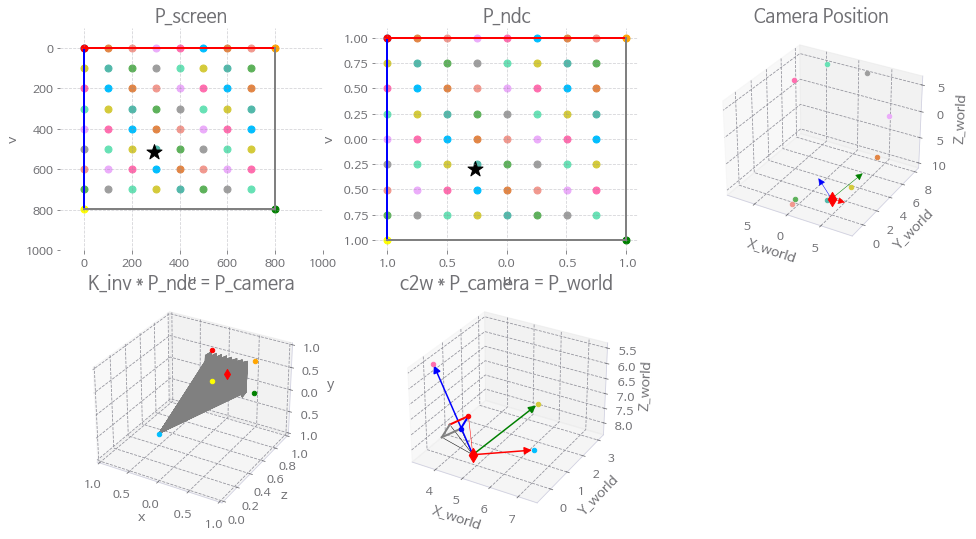

In [74]:
cam_idx = 0


fig = plt.figure(figsize=(16, 9))

ax = fig.add_subplot(2, 3, 1)

plt.title("P_screen")
plt.xlabel("u")
plt.ylabel("v")

plt.xlim(-100, 1000)  # u축 (=x)
plt.ylim(1000, -100)  # v축 (=y)


# Screen 좌표계에서 정의된 각 픽셀 좌표 시각화
xs = screen_px[:W][::100][:, 0]        # screen pixels의 width(0 ~ 799)를 100 간격으로 나눔
ys = screen_px[::W][::100][:, 1]                  # screen pixels의 height(0 ~ 799)를 100 간격으로 나눔

for x in xs:
    for y in ys:
        plt.scatter(x.item(), y.item(), cmap='b')


ndc2screen_true = pytorch3d.renderer.cameras.get_ndc_to_screen_transform(cameras, image_size=(800, 800), with_xyflip=True)

principal = torch.ones((1, 3))
principal[:, :2] = cameras.principal_point[cam_idx]
principal_screen = ndc2screen_true.transform_points(principal)[cam_idx]
print("Principal point in Screen : ", principal_screen)

plt.scatter(principal_screen[0][0].item(), principal_screen[0][1].item(), c='black', marker='*', s=250)

# screen의 left_top
left_top = screen_bound[0].numpy()
plt.scatter(left_top[0], left_top[1], c='red')
# screen의 right_top
right_top = screen_bound[1].numpy()
plt.scatter(right_top[0], right_top[1], c='orange')
# screen의 left_bottom
left_bottom = screen_bound[2].numpy()
plt.scatter(left_bottom[0], left_bottom[1], c='yellow')
# screen의 right_bottom
right_bottom = screen_bound[3].numpy()
plt.scatter(right_bottom[0], right_bottom[1], c='green')

# left
plt.plot(np.linspace(left_top[0], left_bottom[0]), np.linspace(left_top[1], left_bottom[1]), 'blue')
# top
plt.plot(np.linspace(left_top[0], right_top[0]), np.linspace(left_top[1], right_top[1]), 'red')
# right
plt.plot(np.linspace(right_top[0], right_bottom[0]), np.linspace(right_top[1], right_bottom[1]), 'gray')
# bottom
plt.plot(np.linspace(right_bottom[0], left_bottom[0]), np.linspace(right_bottom[1], left_bottom[1]), 'gray')

# ###############################################################

ax = fig.add_subplot(2, 3, 2)

ax.set_title("P_ndc")
ax.set_xlabel("u")
ax.set_ylabel("v")

# ax.set_xlim(-1.5, 1.5)  # u축 (=x)
# ax.set_ylim(1.5, -1.5)  # v축 (=y)
ax.invert_xaxis()
# ax.invert_yaxis()

# NDC 좌표계에서 정의된 각 픽셀 좌표 시각화
xs = ndc_px[:W][::100][:, 0]        # ndc pixels의 width(0 ~ 799)를 100 간격으로 나눔
ys = ndc_px[::W][::100][:, 1]                  # ndc pixels의 height(0 ~ 799)를 100 간격으로 나눔

for x in xs:
    for y in ys:
        ax.scatter(x.item(), y.item(), cmap='b')

principal_ndc = torch.ones((1, 3))
principal_ndc[:, :2] = cameras.principal_point[cam_idx]
print("Principal point in NDC : ", principal_ndc)

ax.scatter(principal_ndc[0][0].item(), principal_ndc[0][1].item(), c='black', marker='*', s=250)

# screen의 left_top
left_top = ndc_bound[0].numpy()
ax.scatter(left_top[0], left_top[1], c='red')
# screen의 right_top
right_top = ndc_bound[1].numpy()
ax.scatter(right_top[0], right_top[1], c='orange')
# screen의 left_bottom
left_bottom = ndc_bound[2].numpy()
ax.scatter(left_bottom[0], left_bottom[1], c='yellow')
# screen의 right_bottom
right_bottom = ndc_bound[3].numpy()
ax.scatter(right_bottom[0], right_bottom[1], c='green')

# left
ax.plot(np.linspace(left_top[0], left_bottom[0]), np.linspace(left_top[1], left_bottom[1]), 'blue')
# top
ax.plot(np.linspace(left_top[0], right_top[0]), np.linspace(left_top[1], right_top[1]), 'red')
# right
ax.plot(np.linspace(right_top[0], right_bottom[0]), np.linspace(right_top[1], right_bottom[1]), 'gray')
# bottom
ax.plot(np.linspace(right_bottom[0], left_bottom[0]), np.linspace(right_bottom[1], left_bottom[1]), 'gray')

# ###############################################################

ax = fig.add_subplot(2, 3, 3, projection='3d')

ax.set_title("Camera Position")

ax.set_xlabel("X_world")
ax.set_ylabel("Y_world")
ax.set_zlabel("Z_world")

ax.view_init(elev=30, azim=120)

for i, (camera_center, R) in enumerate(zip(camera_centers, c2w_Rs)):
    x, y, z = camera_center

    ax.scatter3D(x, y, z, cmap='blues')

    if i == cam_idx:
        ax.scatter3D(x, y, z, c='red', marker='d', s=100)

        # 카메라의 +x, +y, +z축
        xx, xy, xz = R[:3, 0]*4
        yx, yy, yz = R[:3, 1]*4
        zx, zy, zz = R[:3, 2]*4

        # 카메라의 x축 그리기
        xs = [x, x+xx]
        ys = [y, y+xy]
        zs = [z, z+xz]
        a = Arrow3D(xs, ys, zs, mutation_scale=15, 
                    lw=0.5, arrowstyle="-|>", color="r")
        ax.add_artist(a)

        # 카메라의 y축 그리기
        xs = [x, x+yx]
        ys = [y, y+yy]
        zs = [z, z+yz]
        a = Arrow3D(xs, ys, zs, mutation_scale=15, 
                    lw=0.5, arrowstyle="-|>", color="g")
        ax.add_artist(a)

        # 카메라의 z축 그리기
        xs = [x, x+zx]
        ys = [y, y+zy]
        zs = [z, z+zz]
        a = Arrow3D(xs, ys, zs, mutation_scale=15, 
                    lw=0.5, arrowstyle="-|>", color="b")
        ax.add_artist(a)

# ###############################################################
ax = fig.add_subplot(2, 3, 4, projection='3d')

ax.set_title("K_inv * P_ndc = P_camera")

ax.set_xlabel("x")
ax.set_ylabel("z")
ax.set_zlabel("y")

ax.set_xlim3d(1, -1)  # u축 (=x)
ax.set_ylim3d(0, 1)     # z축 (=1)
ax.set_zlim3d(-1, 1)  # v축 (=y)

# intrinsic_inv만 곱한 ray 시각화
for ray_o, ray_d in zip(rays_o_cam[::300], rays_d_cam[::300]):
    xs = [ray_o[0].item(), ray_d[0].item()]
    ys = [ray_o[1].item(), ray_d[1].item()]
    zs = [ray_o[2].item(), ray_d[2].item()]

    a = Arrow3D(xs, zs, ys, mutation_scale=15, 
                    lw=0.5, arrowstyle="-|>", color="gray")
    ax.add_artist(a)

x, y, z = ray_o[0].item(), ray_o[1].item(), ray_o[2].item()
ax.scatter3D(x, z, y, cmap='Greens')

principal_ = torch.ones(1, 3)
principal_[..., :2] = principal_ndc[..., :2]
principal_cam = K_inv.transform_points(principal_)
print("Principal point in cam : ", principal_cam)

x, y, z = principal_cam[0][0].item(), principal_cam[0][1].item(), principal_cam[0][2].item()
ax.scatter3D(x, z, y, c='red', marker='d', s=50)

# image의 left_top
left_top = cam_bound_ray[0].numpy()
ax.scatter3D(left_top[0], left_top[2], left_top[1], c='red')
# image의 right_top
right_top = cam_bound_ray[1].numpy()
ax.scatter3D(right_top[0], right_top[2], right_top[1], c='orange')
# image의 left_bottom
left_bottom = cam_bound_ray[2].numpy()
ax.scatter3D(left_bottom[0], left_bottom[2], left_bottom[1], c='yellow')
# image의 right_bottom
right_bottom = cam_bound_ray[3].numpy()
ax.scatter3D(right_bottom[0], right_bottom[2], right_bottom[1], c='green')

# ###############################################################
ax = fig.add_subplot(2, 3, 5, projection='3d')

ax.set_title("c2w * P_camera = P_world")

ax.set_xlabel("X_world")
ax.set_ylabel("Y_world")
ax.set_zlabel("Z_world")

# ax.set_xlim(0, 10)
# ax.set_ylim(0, 10)
# ax.set_zlim(0, 10)

ax.view_init(elev=30, azim=120)

x, y, z = camera_centers[cam_idx]

ax.scatter3D(x, y, z, c='red', marker='d', s=100)

for i, ray_d in enumerate(world_bound_ray):
    xs = [x, ray_d[0].item()]
    ys = [y, ray_d[1].item()]
    zs = [z, ray_d[2].item()]

    if i == 0:
        a = Arrow3D(xs, ys, zs, mutation_scale=15, 
                        lw=0.5, arrowstyle="-", color="r")
    else:
        a = Arrow3D(xs, ys, zs, mutation_scale=15, 
                        lw=0.5, arrowstyle="-", color="black")
    ax.add_artist(a)

left_top = world_bound_ray[0].numpy()
right_top = world_bound_ray[1].numpy()
left_bottom = world_bound_ray[2].numpy()
right_bottom = world_bound_ray[3].numpy()

# left
ax.plot(np.linspace(left_top[0], left_bottom[0]), np.linspace(left_top[1], left_bottom[1]), np.linspace(left_top[2], left_bottom[2]), 'blue')
# top
ax.plot(np.linspace(left_top[0], right_top[0]), np.linspace(left_top[1], right_top[1]), np.linspace(left_top[2], right_top[2]), 'red')
# right
ax.plot(np.linspace(right_top[0], right_bottom[0]), np.linspace(right_top[1], right_bottom[1]), np.linspace(right_top[2], right_bottom[2]), 'gray')
# bottom
ax.plot(np.linspace(right_bottom[0], left_bottom[0]), np.linspace(right_bottom[1], left_bottom[1]), np.linspace(right_bottom[2], left_bottom[2]), 'gray')

# left-top (= image의 (0,0))
ax.scatter3D(left_top[0], left_top[1], left_top[2], c='red')
# left-bottom (= image의 (H-1,0))
ax.scatter3D(left_bottom[0], left_bottom[1], left_bottom[2], c='blue')

# 카메라의 +x, +y, +z축
xx, xy, xz = (R[:3, 0]*3).numpy()
yx, yy, yz = (R[:3, 1]*3).numpy()
zx, zy, zz = (R[:3, 2]*3).numpy()

# 카메라의 x축 그리기
xs = [x, x+xx]
ys = [y, y+xy]
zs = [z, z+xz]
a = Arrow3D(xs, ys, zs, mutation_scale=15, 
            lw=1.5, arrowstyle="-|>", color="r")
ax.add_artist(a)
ax.scatter3D(xs[1], ys[1], zs[1])

# 카메라의 y축 그리기
xs = [x, x+yx]
ys = [y, y+yy]
zs = [z, z+yz]
a = Arrow3D(xs, ys, zs, mutation_scale=15, 
            lw=1.5, arrowstyle="-|>", color="g")
ax.add_artist(a)
ax.scatter3D(xs[1], ys[1], zs[1])

# 카메라의 z축 그리기
xs = [x, x+zx]
ys = [y, y+zy]
zs = [z, z+zz]
a = Arrow3D(xs, ys, zs, mutation_scale=15, 
            lw=1.5, arrowstyle="-|>", color="b")
ax.add_artist(a)
ax.scatter3D(xs[1], ys[1], zs[1])

In [ ]:
point_cloud = frame_data.sequence_point_cloud

In [ ]:
point_cloud.points_list()[0].shape

torch.Size([980001, 3])

In [ ]:
torch.max(point_cloud.points_list()[0], dim=0)[0]

tensor([2.1681, 2.8764, 2.2372])

tensor([[3.1780e+02, 3.9779e+02, 1.0058e-01],
        [1.2306e+02, 2.0215e+02, 1.2150e-01],
        [2.4155e+02, 4.3615e+02, 8.7278e-02],
        [1.7771e+02, 3.8240e+02, 9.5321e-02],
        [1.6215e+02, 3.9007e+02, 1.0630e-01]])


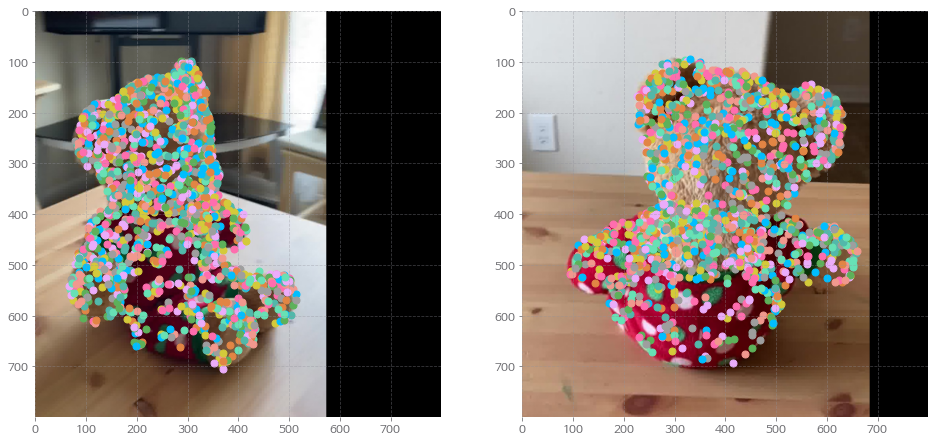

In [ ]:
plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1)

cam_idx = 0
img = imgs[cam_idx, :, :].numpy().transpose(1, 2, 0)
plt.imshow(img)

proj_points = cameras.transform_points_screen(point_cloud.points_list()[0], image_size=(800, 800))[cam_idx, :, :]
print(proj_points[:5])

for point in proj_points[::600][:]:
    x = point[0].item()
    y = point[1].item()

    plt.scatter(x, y)
####################################
plt.subplot(1, 2, 2)

cam_idx = 5
img = imgs[cam_idx, :, :].numpy().transpose(1, 2, 0)
plt.imshow(img)

proj_points = cameras.transform_points_screen(point_cloud.points_list()[0], image_size=(800, 800))[cam_idx, :, :2]

for point in proj_points[::600]:
    x = point[0].item()
    y = point[1].item()

    plt.scatter(x, y)

***

## Cameras의 Intrinsic matrix K 불러오기

`cameras.get_projection_transform()`

근데 일반적인 K랑 모양이 좀 다름... Transpose 한 것처럼 생김...

In [86]:
cam_idx = 0

K_transform = cameras.get_projection_transform()[cam_idx]

print("< K Matrix >\n", K_transform.get_matrix())

print("\n< Focal length >\n", cameras.focal_length[cam_idx])

print("\n< Principal point >\n", cameras.principal_point[cam_idx])

< K Matrix >
 tensor([[[ 2.7659,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  2.7659,  0.0000,  0.0000],
         [ 0.2678, -0.2952,  0.0000,  1.0000],
         [ 0.0000,  0.0000,  1.0000,  0.0000]]])

< Focal length >
 tensor([2.7659, 2.7659])

< Principal point >
 tensor([ 0.2678, -0.2952])


***

## Cameras의 Intrinsic matrix K 역행렬 불러오기

`cameras.get_projection_transform().inverse()`

In [84]:
cam_idx = 0

K_inv_transform = cameras.get_projection_transform()[cam_idx].inverse()

print("< K^-1 Matrix >\n", K_inv_transform.get_matrix())

# print("\n< Focal length >\n", cameras.focal_length[cam_idx])

# print("\n< Principal point >\n", cameras.principal_point[cam_idx])

< K^-1 Matrix >
 tensor([[[ 0.3615, -0.0000, -0.0000,  0.0000],
         [ 0.0000,  0.3615, -0.0000,  0.0000],
         [ 0.0000,  0.0000, -0.0000,  1.0000],
         [-0.0968,  0.1067,  1.0000,  0.0000]]])


***

## Cameras의 Extrinsic matrix RT 불러오기 >>>> w2c

`cameras.get_world_to_view_transform()`

이것도 이상하게 생김...

```
M = [
        [Rxx, Ryx, Rzx, 0],
        [Rxy, Ryy, Rzy, 0],
        [Rxz, Ryz, Rzz, 0],
        [Tx,  Ty,  Tz,  1],
    ]
```

In [83]:
cam_idx = 0

w2c_transform = cameras.get_world_to_view_transform()[cam_idx]

print("< RT Matrix >\n", w2c_transform.get_matrix())

print("\n< Rotation Matrix >\n", cameras.R[cam_idx])

print("\n< Translation Matrix >\n", cameras.T[cam_idx])

< RT Matrix >
 tensor([[[-0.8319,  0.2648,  0.4878,  0.0000],
         [-0.2223, -0.9642,  0.1443,  0.0000],
         [ 0.5086,  0.0117,  0.8610,  0.0000],
         [ 0.1924,  1.1848,  9.4113,  1.0000]]])

< Rotation Matrix >
 tensor([[-0.8319,  0.2648,  0.4878],
        [-0.2223, -0.9642,  0.1443],
        [ 0.5086,  0.0117,  0.8610]])

< Translation Matrix >
 tensor([0.1924, 1.1848, 9.4113])


***

## Cameras의 Extrinsic matrix RT 역행렬 불러오기 >>>> c2w

`cameras.get_world_to_view_transform().inverse()`

In [85]:
cam_idx = 0

c2w_transform = cameras.get_world_to_view_transform()[cam_idx].inverse()

print("< (RT)^-1 Matrix >\n", c2w_transform.get_matrix())

print("\n< Inverse Rotation Matrix (=R.T = R^-1) >\n", torch.inverse(cameras.R[cam_idx]))

print("\n< Inverse Translation Matrix (=R.T x -T)>\n", -cameras.T[cam_idx].matmul(torch.inverse(cameras.R[cam_idx])))

< (RT)^-1 Matrix >
 tensor([[[-8.3185e-01, -2.2225e-01,  5.0855e-01,  0.0000e+00],
         [ 2.6475e-01, -9.6425e-01,  1.1659e-02,  1.8277e-08],
         [ 4.8778e-01,  1.4434e-01,  8.6095e-01, -7.4506e-09],
         [-4.7442e+00, -1.7325e-01, -8.2143e+00,  1.0000e+00]]])

< Inverse Rotation Matrix (=R.T = R^-1) >
 tensor([[-0.8319, -0.2223,  0.5086],
        [ 0.2648, -0.9642,  0.0117],
        [ 0.4878,  0.1443,  0.8610]])

< Inverse Translation Matrix (=R.T x -T)>
 tensor([-4.7442, -0.1732, -8.2143])


In [89]:
# world 좌표계에서의 point
P_world = torch.tensor([[[10, 20, 30]]], dtype=torch.float32)        # (B, N_p, 3)
print("P_world : ", P_world)

# 카메라 좌표계에서의 point
P_cam = w2c_transform.transform_points(P_world)
print("\nP_cam : ", P_cam)

# 이미지 좌표계에서의 point
P_img = K_transform.transform_points(P_cam)
print("\nP_img : ", P_img)

# 다시 카메라 좌표계로
P_cam_again = K_inv_transform.transform_points(P_img)
print("\nP_cam_again : ", P_cam_again)

# 다시 world 좌표계로
P_world_again = c2w_transform.transform_points(P_cam_again)
print("\nP_world_again : ", P_world_again)

P_world :  tensor([[[10., 20., 30.]]])

P_cam :  tensor([[[  2.6853, -15.1029,  43.0044]]])

P_img :  tensor([[[ 0.4405, -1.2665,  0.0233]]])

P_cam_again :  tensor([[[  2.6853, -15.1029,  43.0044]]])

P_world_again :  tensor([[[10.0000, 20.0000, 30.0000]]])


In [122]:
# ndc 또는 screen 좌표계의 point들을 camera 또는 world 좌표계로 변환
# world_coordinates = True면 world로...
# world_coordinates = False면 camera로...

p_cam = cameras.unproject_points(rays_d_ndc, world_coordinates=False, scaled_depth_input=True)[cam_idx]
p_world = cameras.unproject_points(rays_d_ndc, world_coordinates=True, scaled_depth_input=True)[cam_idx]

In [123]:
rays_d_ndc[:5]

tensor([[1.0000, 1.0000, 1.0000],
        [0.9975, 1.0000, 1.0000],
        [0.9950, 1.0000, 1.0000],
        [0.9925, 1.0000, 1.0000],
        [0.9900, 1.0000, 1.0000]])

In [124]:
p_cam[:5]

tensor([[0.2705, 0.4104, 1.0000],
        [0.2697, 0.4104, 1.0000],
        [0.2688, 0.4104, 1.0000],
        [0.2679, 0.4104, 1.0000],
        [0.2670, 0.4104, 1.0000]])

In [125]:
principal_ndc = torch.ones((1, 3))
principal_ndc[:, :2] = cameras.principal_point[cam_idx]

principal_cam = cameras.unproject_points(principal_ndc, world_coordinates=False, scaled_depth_input=True)[cam_idx]
principal_world = cameras.unproject_points(principal_ndc, world_coordinates=True, scaled_depth_input=True)[cam_idx]

print(principal_ndc, principal_cam, principal_world)

tensor([[ 0.2355, -0.1597,  1.0000]]) tensor([[0., 0., 1.]]) tensor([[-0.0185,  0.8861, -8.7608]])


In [126]:
boundary_ndc = [rays_d_ndc[0], rays_d_ndc[W-1], rays_d_ndc[W*(H-1)], rays_d_ndc[-1]]
boundary_ndc = torch.stack(boundary_ndc)

boundary_cam = cameras.unproject_points(boundary_ndc, world_coordinates=False, scaled_depth_input=True)[cam_idx]
boundary_world = cameras.unproject_points(boundary_ndc, world_coordinates=True, scaled_depth_input=True)[cam_idx]

print(boundary_ndc)
print(boundary_cam)
print(boundary_world)

tensor([[ 1.,  1.,  1.],
        [-1.,  1.,  1.],
        [ 1., -1.,  1.],
        [-1., -1.,  1.]])
tensor([[ 0.2705,  0.4104,  1.0000],
        [-0.4372,  0.4104,  1.0000],
        [ 0.2705, -0.2974,  1.0000],
        [-0.4372, -0.2974,  1.0000]])
tensor([[-0.2898,  0.4762, -8.7624],
        [ 0.4179,  0.4750, -8.7607],
        [-0.2885,  1.1840, -8.7607],
        [ 0.4192,  1.1827, -8.7590]])
